# k-means with text data

In this assignment you will
* Cluster Wikipedia documents using k-means
* Explore the role of random initialization on the quality of the clustering
* Explore how results differ after changing the number of clusters
* Evaluate clustering, both quantitatively and qualitatively

When properly executed, clustering uncovers valuable insights from a set of unlabeled documents.

**Note to Amazon EC2 users**: To conserve memory, make sure to stop all the other notebooks before running this notebook.

## Import necessary packages

In [1]:
#from __future__ import print_function # to conform python 2.x print to python 3.x
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

%matplotlib inline

## Load data, extract features

To work with text data, we must first convert the documents into numerical features. As in the first assignment, let's extract TF-IDF features for each article.

In [2]:
#wiki = turicreate.SFrame('people_wiki.sframe/')
data = pd.read_csv("people_wiki.csv", header=0)

In [3]:
#wiki['tf_idf'] = turicreate.text_analytics.tf_idf(wiki['text'])
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=200000) # , sublinear_tf=True
tf_idf = data_matrix = vectorizer.fit_transform(data["text"])

For the remainder of the assignment, we will use sparse matrices. Sparse matrices are matrices that have a small number of nonzero entries. A good data structure for sparse matrices would only store the nonzero entries to save space and speed up computation. SciPy provides a highly-optimized library for sparse matrices. Many matrix operations available for NumPy arrays are also available for SciPy sparse matrices.

The above matrix contains a TF-IDF score for each of the 59071 pages in the data set and each of the 200000 most common words found in the whole document.

In [4]:
data_matrix.shape

(59071, 200000)

## Normalize all vectors

As discussed in the previous assignment, Euclidean distance can be a poor metric of similarity between documents, as it unfairly penalizes long articles. For a reasonable assessment of similarity, we should disregard the length information and use length-agnostic metrics, such as cosine distance.

The k-means algorithm does not directly work with cosine distance, so we take an alternative route to remove length information: we normalize all vectors to be unit length. It turns out that Euclidean distance closely mimics cosine distance when all vectors are unit length. In particular, the squared Euclidean distance between any two vectors of length one is directly proportional to their cosine distance.

We can prove this as follows. Let $\mathbf{x}$ and $\mathbf{y}$ be normalized vectors, i.e. unit vectors, so that $\|\mathbf{x}\|=\|\mathbf{y}\|=1$. Write the squared Euclidean distance as the dot product of $(\mathbf{x} - \mathbf{y})$ to itself:
\begin{align*}
\|\mathbf{x} - \mathbf{y}\|^2 &= (\mathbf{x} - \mathbf{y})^T(\mathbf{x} - \mathbf{y})\\
                              &= (\mathbf{x}^T \mathbf{x}) - 2(\mathbf{x}^T \mathbf{y}) + (\mathbf{y}^T \mathbf{y})\\
                              &= \|\mathbf{x}\|^2 - 2(\mathbf{x}^T \mathbf{y}) + \|\mathbf{y}\|^2\\
                              &= 2 - 2(\mathbf{x}^T \mathbf{y})\\
                              &= 2(1 - (\mathbf{x}^T \mathbf{y}))\\
                              &= 2\left(1 - \frac{\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\|\|\mathbf{y}\|}\right)\\
                              &= 2\left[\text{cosine distance}\right]
\end{align*}

This tells us that two **unit vectors** that are close in Euclidean distance are also close in cosine distance. Thus, the k-means algorithm (which naturally uses Euclidean distances) on normalized vectors will produce the same results as clustering using cosine distance as a distance metric.

## Implement k-means

Let us implement the k-means algorithm. First, we choose an initial set of centroids. A common practice is to choose randomly from the data points.

**Note:** We specify a seed here, so that everyone gets the same answer. In practice, we highly recommend to use different seeds every time (for instance, by using the current timestamp).

In [5]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

After initialization, the k-means algorithm iterates between the following two steps:
1. Assign each data point to the closest centroid.
$$
z_i \gets \mathrm{argmin}_j \|\mu_j - \mathbf{x}_i\|^2
$$
2. Revise centroids as the mean of the assigned data points.
$$
\mu_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i
$$

In pseudocode, we iteratively do the following:
```
cluster_assignment = assign_clusters(data, centroids)
centroids = revise_centroids(data, k, cluster_assignment)
```

### Assigning clusters

How do we implement Step 1 of the main k-means loop above? First import `pairwise_distances` function from scikit-learn, which calculates Euclidean distances between rows of given arrays. See [this documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html) for more information.

For the sake of demonstration, let's look at documents 100 through 102 as query documents and compute the distances between each of these documents and every other document in the corpus. In the k-means algorithm, we will have to compute pairwise distances between the set of centroids and the set of documents.

In [6]:
from sklearn.metrics import pairwise_distances

# Get the TF-IDF vectors for documents 100 through 102.
queries = data_matrix[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(data_matrix, queries, metric='euclidean')

print(dist)

[[1.34836014 1.28720696]
 [1.38416243 1.38889899]
 [1.35115021 1.36364876]
 ...
 [1.37559731 1.34862205]
 [1.36099317 1.24365439]
 [1.34380117 1.36355488]]


More formally, `dist[i,j]` is assigned the distance between the `i`th row of `X` (i.e., `X[i,:]`) and the `j`th row of `Y` (i.e., `Y[j,:]`).

**Checkpoint:** For a moment, suppose that we initialize three centroids with the first 3 rows of `tf_idf`. Write code to compute distances from each of the centroids to all data points in `tf_idf`. Then find the distance between row 430 of `tf_idf` and the second centroid and save it to `dist`.

In [7]:
three_centroids = data_matrix[0:3,:]
dist_three_centroids = pairwise_distances(data_matrix, three_centroids, metric='euclidean')
dist = dist_three_centroids[430][1]
print(dist)

1.3826776378359966


In [8]:
'''Test cell'''
if np.allclose(dist, pairwise_distances(data_matrix[430,:], data_matrix[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


**Checkpoint:** Next, given the pairwise distances, we take the minimum of the distances for each data point. Fittingly, NumPy provides an `argmin` function. See [this documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.argmin.html) for details.

Read the documentation and write code to produce a 1D array whose i-th entry indicates the centroid that is the closest to the i-th data point. Use the list of distances from the previous checkpoint and save them as `distances`. The value 0 indicates closeness to the first centroid, 1 indicates closeness to the second centroid, and so forth. Save this array as `closest_cluster`.

**Hint:** the resulting array should be as long as the number of data points.

In [9]:
distances = pairwise_distances(data_matrix, data_matrix[:3,:], metric='euclidean')
closest_cluster = np.argmin(distances, axis=1)

In [10]:
'''Test cell'''
reference = [list(row).index(min(row)) for row in distances]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


**Checkpoint:** Let's put these steps together.  First, initialize three centroids with the first 3 rows of `tf_idf`. Then, compute distances from each of the centroids to all data points in `tf_idf`. Finally, use these distance calculations to compute cluster assignments and assign them to `cluster_assignment`.

In [11]:
centroids = data_matrix[:3,:]
distances = pairwise_distances(data_matrix, centroids, metric='euclidean')
cluster_assignment = np.argmin(distances, axis=1)

In [12]:
if len(cluster_assignment)==59071 and \
   np.array_equal(np.bincount(cluster_assignment), np.array([52863, 177, 6031])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

Pass


Now we are ready to fill in the blanks in this function:

In [13]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')   # YOUR CODE HERE
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)   # YOUR CODE HERE
    
    return cluster_assignment

**Checkpoint**. For the last time, let us check if Step 1 was implemented correctly. With rows 0, 5, 10, and 15 of `tf_idf` as an initial set of centroids, we assign cluster labels to rows 130, 140, 150, ..., and 220 of `tf_idf`. The resulting cluster labels should be `[0, 0, 2, 0, 3, 0, 2, 0, 0, 1]`.

In [14]:
test_cluster = assign_clusters(tf_idf[130:230:10], tf_idf[0:20:5])
print(test_cluster)
if np.allclose(test_cluster, np.array([0, 0, 2, 0, 3, 0, 2, 0, 0, 1])):
    print('Pass')
else:
    print('Check your code again.')

[0 0 2 0 3 0 2 0 0 1]
Pass


### Revising clusters

Let's turn to Step 2, where we compute the new centroids given the cluster assignments. 

SciPy and NumPy arrays allow for filtering via Boolean masks. For instance, we filter all data points that are assigned to cluster 0 by writing
```
data[cluster_assignment==0,:]
```

To develop intuition about filtering, let's look at a toy example consisting of 3 data points and 2 clusters.

In [15]:
mock_data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
mock_centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

Let's assign these data points to the closest centroid.

In [16]:
cluster_assignment = assign_clusters(mock_data, mock_centroids)
print(cluster_assignment)

[0 1 0]


The expression `cluster_assignment==1` gives a list of Booleans that says whether each data point is assigned to cluster 1 or not:

In [17]:
cluster_assignment==1

array([False,  True, False])

Likewise for cluster 0:

In [18]:
cluster_assignment==0

array([ True, False,  True])

In lieu of indices, we can put in the list of Booleans to pick and choose rows. Only the rows that correspond to a `True` entry will be retained.

First, let's look at the data points (i.e., their values) assigned to cluster 1:

In [19]:
mock_data[cluster_assignment==1]

array([[0., 0., 0.]])

This makes sense since [0 0 0] is closer to [0 -0.5 0] than to [0.5 0.5 0].

Now let's look at the data points assigned to cluster 0:

In [20]:
mock_data[cluster_assignment==0]

array([[1., 2., 0.],
       [2., 2., 0.]])

Again, this makes sense since these values are each closer to [0.5 0.5 0] than to [0 -0.5 0].

Given all the data points in a cluster, it only remains to compute the mean. Use [np.mean()](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.mean.html). By default, the function averages all elements in a 2D array. To compute row-wise or column-wise means, add the `axis` argument. See the linked documentation for details. 

Use this function to average the data points in cluster 0:

In [21]:
mock_data[cluster_assignment==0].mean(axis=0)

array([1.5, 2. , 0. ])

We are now ready to complete this function:

In [22]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i,:]   # YOUR CODE HERE
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)  # YOUR CODE HERE
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

**Checkpoint**. Let's check our Step 2 implementation. Letting rows 0, 10, ..., 90 of `tf_idf` as the data points and the cluster labels `[0, 1, 1, 0, 0, 2, 0, 2, 2, 1]`, we compute the next set of centroids. Each centroid is given by the average of all member data points in corresponding cluster.

In [23]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


How can we tell if the k-means algorithm is converging? We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as
$$
J(\mathcal{Z},\mu) = \sum_{j=1}^k \sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|^2.
$$
The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

In [24]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

Let's compute the cluster heterogeneity for the 2-cluster example we've been considering based on our current cluster assignments and centroids.

In [25]:
compute_heterogeneity(mock_data, 2, mock_centroids, cluster_assignment)

7.25

### Combining into a single function

Once the two k-means steps have been implemented, as well as our heterogeneity metric we wish to monitor, it is only a matter of putting these functions together to write a k-means algorithm that

* Repeatedly performs Steps 1 and 2
* Tracks convergence metrics
* Stops if either no assignment changed or we reach a certain number of iterations.

In [26]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        # YOUR CODE HERE
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        # YOUR CODE HERE
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # YOUR CODE HERE
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

## Plotting convergence metric

We can use the above function to plot the convergence metric across iterations.

In [27]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

Let's consider running k-means with K=3 clusters for a maximum of 400 iterations, recording cluster heterogeneity at every step.  Then, let's plot the heterogeneity over iterations using the plotting function above.

0
1
     2966 elements changed their cluster assignment.
2
     3627 elements changed their cluster assignment.
3
     4632 elements changed their cluster assignment.
4
     3299 elements changed their cluster assignment.
5
     2359 elements changed their cluster assignment.
6
     1642 elements changed their cluster assignment.
7
     1170 elements changed their cluster assignment.
8
      870 elements changed their cluster assignment.
9
      683 elements changed their cluster assignment.
10
      569 elements changed their cluster assignment.
11
      459 elements changed their cluster assignment.
12
      365 elements changed their cluster assignment.
13
      290 elements changed their cluster assignment.
14
      214 elements changed their cluster assignment.
15
      163 elements changed their cluster assignment.
16
      130 elements changed their cluster assignment.
17
       99 elements changed their cluster assignment.
18
       74 elements changed their cluster assignment.

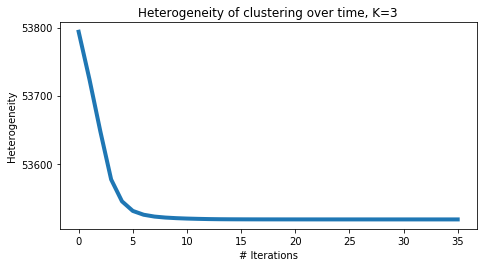

In [28]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

**Quiz Question**. (True/False) The clustering objective (heterogeneity) is non-increasing for this example.

**Quiz Question**. Let's step back from this particular example. If the clustering objective (heterogeneity) would ever increase when running k-means, that would indicate: (choose one)

1. k-means algorithm got stuck in a bad local minimum
2. There is a bug in the k-means code
3. All data points consist of exact duplicates
4. Nothing is wrong. The objective should generally go down sooner or later.

**Quiz Question**. Which of the cluster contains the greatest number of data points in the end? Hint: Use [`np.bincount()`](http://docs.scipy.org/doc/numpy-1.11.0/reference/generated/numpy.bincount.html) to count occurrences of each cluster label.
 1. Cluster #0
 2. Cluster #1
 3. Cluster #2

In [35]:
np.bincount(cluster_assignment).argmax()

0

## Beware of local maxima

One weakness of k-means is that it tends to get stuck in a local minimum. To see this, let us run k-means multiple times, with different initial centroids created using different random seeds.

**Note:** Again, in practice, you should set different seeds for every run. We give you a list of seeds for this assignment so that everyone gets the same answer.

This may take several minutes to run.

In [36]:
k = 10
heterogeneity = {}
cluster_assignment_dict = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)

    # This is the line we added for the next quiz question
    cluster_assignment_dict[seed] = np.bincount(cluster_assignment)
    
#    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    # And this is the modified print statement
    print('seed={0:06d}, heterogeneity={1:.5f}, cluster_distribution={2}'.format(seed, heterogeneity[seed], 
                                           cluster_assignment_dict[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=52497.92614, cluster_distribution=[15987  7572   380  3367  1378  7986   480  6881  6853  8187]
seed=020000, heterogeneity=52468.11626, cluster_distribution=[ 9039   720  5060  3645 15785  7632  6453  1840  3847  5050]
seed=040000, heterogeneity=52530.96764, cluster_distribution=[ 6649  5929     7  2346  8489  6477  8084  5112  2963 13015]
seed=060000, heterogeneity=52408.40408, cluster_distribution=[ 2775  7725  7738  3534  1705 13885  3589  6755  7185  4180]
seed=080000, heterogeneity=52377.42070, cluster_distribution=[14624  3163  6792  1697  7064  1982  7534  8117  4488  3610]
seed=100000, heterogeneity=52480.06353, cluster_distribution=[ 8037   739  8021  4036  7473  7313  3413 16576  1831  1632]
seed=120000, heterogeneity=52507.42954, cluster_distribution=[ 6870  1822  5370  8554  5494  4142    20  8022  5107 13670]
340.17422246932983


Notice the variation in heterogeneity for different initializations. This indicates that k-means sometimes gets stuck at a bad local minimum.

**Quiz Question**. Another way to capture the effect of changing initialization is to look at the distribution of cluster assignments. Add a line to the code above to compute the size (# of member data points) of clusters for each run of k-means. Look at the size of the largest cluster (most # of member data points) across multiple runs, with seeds 0, 20000, ..., 120000. How much does this measure vary across the runs? What is the minimum and maximum values this quantity takes?

One effective way to counter this tendency is to use **k-means++** to provide a smart initialization. This method tries to spread out the initial set of centroids so that they are not too close together. It is known to improve the quality of local optima and lower average runtime.

In [37]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2,axis=1)
    
    return centroids

Let's now rerun k-means with 10 clusters using the same set of seeds, but always using k-means++ to initialize the algorithm.

This may take several minutes to run.

In [38]:
# %%time 

start = time.time()
k = 10
heterogeneity_smart = {}
seeds = [0, 20000, 40000, 60000, 80000, 100000, 120000]
for seed in seeds:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()

end = time.time()
print(end-start)

seed=000000, heterogeneity=52450.03677
seed=020000, heterogeneity=52407.72621
seed=040000, heterogeneity=52417.08794
seed=060000, heterogeneity=52428.73417
seed=080000, heterogeneity=52438.73426
seed=100000, heterogeneity=52426.20003
seed=120000, heterogeneity=52510.17190
463.0376114845276


Let's compare the set of cluster heterogeneities we got from our 7 restarts of k-means using random initialization compared to the 7 restarts of k-means using k-means++ as a smart initialization.

The following code produces a [box plot](http://matplotlib.org/api/pyplot_api.html) for each of these methods, indicating the spread of values produced by each method.

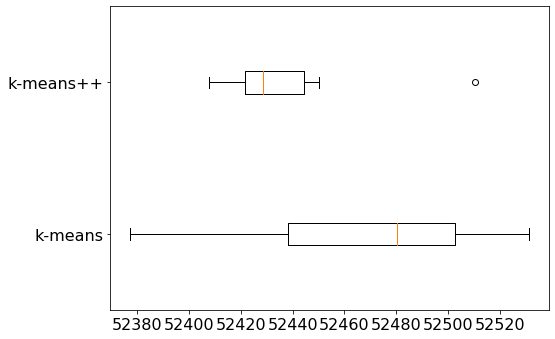

In [39]:
plt.figure(figsize=(8,5))
plt.boxplot([list(heterogeneity.values()), list(heterogeneity_smart.values())], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

A few things to notice from the box plot:
* On average, k-means++ produces a better clustering than Random initialization.
* Variation in clustering quality is smaller for k-means++.

**In general, you should run k-means at least a few times with different initializations and then return the run resulting in the lowest heterogeneity.** Let us write a function that runs k-means multiple times and picks the best run that minimizes heterogeneity. The function accepts an optional list of seed values to be used for the multiple runs; if no such list is provided, the current UTC time is used as seed values.

In [40]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in range(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
        # YOUR CODE HERE
        initial_centroids = smart_initialize(data, k, seed)
        
        # Run k-means
        # YOUR CODE HERE
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter=400, record_heteroheneity=None, verbose=False)
        
        # To save time, compute heterogeneity only once in the end
        # YOUR CODE HERE
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

## How to choose K

Since we are measuring the tightness of the clusters, a higher value of K reduces the possible heterogeneity metric by definition.  For example, if we have N data points and set K=N clusters, then we could have 0 cluster heterogeneity by setting the N centroids equal to the values of the N data points. (Note: Not all runs for larger K will result in lower heterogeneity than a single run with smaller K due to local optima.)  Let's explore this general trend for ourselves by performing the following analysis.

Use the `kmeans_multiple_runs` function to run k-means with five different values of K.  For each K, use k-means++ and multiple runs to pick the best solution.  In what follows, we consider K=2,10,25,50,100 and 7 restarts for each setting.

**IMPORTANT: The code block below will take about 10 minutes to finish**

In order to speed up the computations, we run them with only one random seed, but for better performance, one should use more seeds and compare the results. If you don't mind running the code for approximately one hour, feel free to uncomment the following line of code below:

`seed_list = [0]#, 20000, 40000, 60000, 80000, 100000, 120000]`

Side note: In practice, a good implementation of k-means would utilize parallelism to run multiple runs of k-means at once. For an example, see [scikit-learn's KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [39]:
#%%time
#import numpy as np 

start_time = time.time()
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

centroids = {}
cluster_assignment = {}
heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]
seed_list = [0]
# Uncomment the following line to run the plot with all the seeds (it may take about an hour to finish).
#seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]

for k in k_list:
    heterogeneity = []
    centroids[k], cluster_assignment[k] = kmeans_multiple_runs(tf_idf, k, maxiter=400,
                                                               num_runs=len(seed_list),                                                               seed_list=seed_list,
                                                               verbose=True)
    score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
    heterogeneity_values.append(score)
print("Run time:", time.time() - start_time)

seed=000000, heterogeneity=56624.28904
seed=000000, heterogeneity=55790.86852
seed=000000, heterogeneity=55104.80659
seed=000000, heterogeneity=54609.72537
seed=000000, heterogeneity=54038.48242
Run time: 451.4265069961548


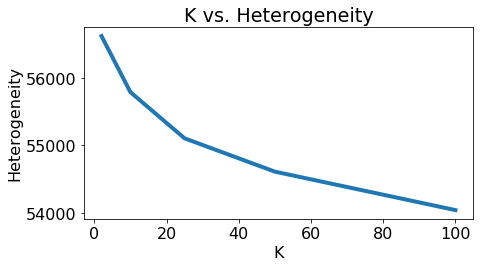

In [40]:
plot_k_vs_heterogeneity(k_list, heterogeneity_values)

In the above plot we show that heterogeneity goes down as we increase the number of clusters. Does this mean we should always favor a higher K? **Not at all!** Setting K too high may end up separating data points that are actually pretty alike. At the extreme, we can set individual data points to be their own clusters (K=N) and achieve zero heterogeneity, but separating each data point into its own cluster is hardly a desirable outcome.